# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

__Initial State__

The initial state is an empty board. In code, this will be represented by a 6x7 numpy array, where each element is 0 (0 represents empty)

__Actions__

The possible actions can be represented by the set $\{0,1,2,3,4,5,6,7\}$

How big is the state space? Give an estimate and explain it.

There are 42 open spaces on the board, and each space can have three different values: red, yellow, or empty (1, -1, 0 in code). This means the upper bound for the state space size is:

$3^{42} \approx 1.09 \times 10^{20}$

However, not all permutations of the board are possible to achieve during a normal game, which is why this estimate is an upper bound.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [2]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [3]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

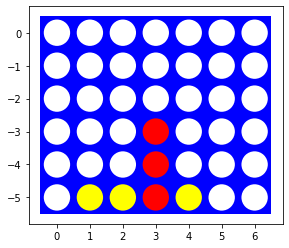

In [4]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

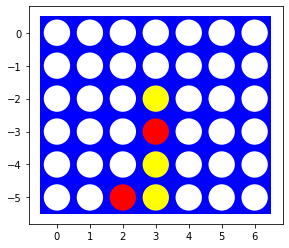

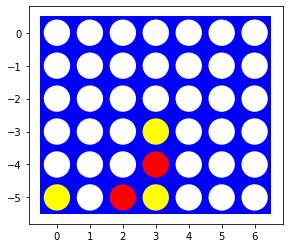

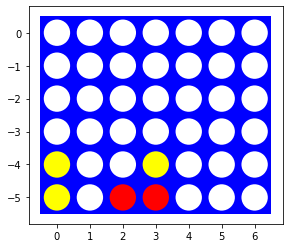

In [5]:
def results(board, action):
    """
    Updates the board according to the given action
    Action is a tuple in the form (column 1, column 2, player)
    Column 1: column to place the piece into if col2 is None, or column to take the opponents piece from otherwise
    Column 2: column to replace the other players piece into, or -1 otherwise
    No error checking in this function, make sure the agents only select legal moves
    """
    b = board.copy()

    if action is None: return
    
    col1, col2, plr = action

    # Normal move
    if col2 is None:
        for i in range(b.shape[0] - 1, -1, -1): # place the piece in the lowest available row
            if b[i][col1] == 0:
                b[i][col1] = plr
                break
    else:
        for i in range(b.shape[0] - 1, 0, -1): # Take out the bottom piece in col1, slide column down by 1
            b[i][col1] = b[i-1][col1]

        for i in range(b.shape[0] - 1, -1, -1): # Place the opponent's piece in col2
            if b[i][col2] == 0:
                b[i][col2] = -plr
                break

    return b

b = empty_board()
results(b, (3, None, -1))
results(b, (2, None, 1))
results(b, (3, None, -1))
results(b, (3, None, 1))
results(b, (3, None, -1))
visualize(b)
results(b, (3, 0, 1))
visualize(b)
results(b, (3, 0, 1))
visualize(b)

__Terminal function__

In [68]:
# Inspired by code on StackOVerflow found here: https://stackoverflow.com/questions/29949169/python-connect-4-check-win-function
from scipy.signal import convolve2d

def terminal(board):
    """Returns true if the board is a terminal state
    lastMove is a tuple (row, column) of the most recent move"""

    if 0 not in board: return 0 # draw state

    cpBoard = np.copy(board) # copy the board for transpositions

    rowKernel = np.array([[1, 1, 1, 1]]) # horizontal and vertical
    diagKernel = np.eye(4)

    for kernel in [rowKernel, diagKernel]:
        result = convolve2d(cpBoard, kernel, mode="valid")
        if (result == 4).any():
            return 1
        if (result == -4).any():
            return -1

        # Transpose board
        cpBoard = np.transpose(cpBoard)
        result = convolve2d(cpBoard, kernel, mode="valid")
        if (result == 4).any():
            return 1
        if (result == -4).any():
            return -1
    
    return None # non terminal state

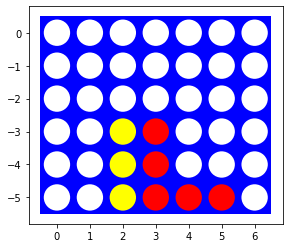

0.2

In [61]:
def utility(board):
    """Returns a utility score for the board
    0.1 is added to the score for each instance of a three in a row
    0.1 is subtracted for each instance of a three in a row for the opposing player"""

    if terminal(board) is not None:
        return terminal(board)


    cpBoard = np.copy(board) # copy the board for transpositions

    rowKernel1 = np.array([[1, 1, 1, 0]]) # horizontal and vertical
    rowKernel2 = np.array([[0, 1, 1, 1]])
    diagKernel = np.eye(3)

    score = 0

    for kernel in [rowKernel1, rowKernel2, diagKernel]:
        result = convolve2d(cpBoard, kernel, mode="valid")
        score += 0.1 * (result == 3).sum()
        score -= 0.1 * (result == -3).sum()

        # Transpose board
        cpBoard = np.transpose(cpBoard)
        result = convolve2d(cpBoard, kernel, mode="valid")
        score += 0.1 * (result == 3).sum()
        score -= 0.1 * (result == -3).sum()
    
    return score

board = empty_board()
results(board, (3, None, 1))
results(board, (3, None, 1))
results(board, (3, None, 1))
results(board, (2, None, -1))
results(board, (2, None, -1))
results(board, (2, None, -1))
results(board, (4, None, 1))
results(board, (5, None, 1))
results(board, (4, None, 1))
visualize(board)

utility(board)


In [67]:
def getActions(board, plr):
    numRows, numCols = board.shape
    legalCols = [col for col in range(numCols) if board[0][col] == 0] # List of columns that arent full
    legalMeanCols = [col for col in range(numCols) if board[numRows - 1][col] == -plr] # List of columns where the mean move is legal

    moves = [(col1, None, plr) for col1 in legalCols] # legal normal moves
    
    for col in legalMeanCols:
        moves += [(col, col2, plr) for col2 in legalCols] # add legal mean moves

    return moves
    


[(0, None, 1),
 (1, None, 1),
 (2, None, 1),
 (3, None, 1),
 (4, None, 1),
 (5, None, 1),
 (6, None, 1)]

__Random move__

In [9]:
def randMove(board, plr):
    """Returns a random choice from among the legal moves"""

    numRows, numCols = board.shape
    legalCols = [col for col in range(numCols) if board[0][col] == 0] # List of columns that arent full
    legalMeanCols = [col for col in range(numCols) if board[numRows - 1][col] == -plr] # List of columns where the mean move is legal

    if np.random.uniform() < 0.5 or len(legalMeanCols) == 0: # 50% chance to choose between normal move and mean move (if mean move is possible)
        randCol = np.random.choice(legalCols)
        return (randCol, -1, plr)
    else:
        randMeanCol = np.random.choice(legalMeanCols)
        return (randMeanCol, np.random.choice(legalCols), plr)

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [10]:
def randAgent(board, plr):
    """Random agent function
    Accepts the board and the player as arguments, and randomly returns a legal move
    """

    numRows, numCols = board.shape
    legalCols = [col for col in range(numCols) if board[0][col] == 0] # List of columns that arent full
    legalMeanCols = [col for col in range(numCols) if board[numRows - 1][col] == -plr] # List of columns where the mean move is legal

    if len(legalCols) == 0: return None # board is full, no actions possible

    if np.random.uniform() < 0.5 or len(legalMeanCols) == 0: # 50% chance to choose between normal move and mean move (if mean move is possible)
        randCol = np.random.choice(legalCols)
        return (randCol, None, plr)
    else:
        randMeanCol = np.random.choice(legalMeanCols)
        return (randMeanCol, np.random.choice(legalCols), plr)

In [11]:
def play(agent1, agent2, debugMode=None, shape=(6,7)):
    """Play a single game with the given agents
    debugMode: None - no visualization
               results - show the final board
               all - show the board after each move
    """
    board = empty_board(shape)
    while terminal(board) is None:
        results(board, agent1(board, 1))
        if debugMode == "all": visualize(board)
        if terminal(board) != None: break

        results(board, agent2(board, -1))
        if debugMode == "all": visualize(board)
    
    if debugMode == "results": visualize(board)
    return terminal(board)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [12]:
p1Wins = 0
p2Wins = 0
draws = 0
for _ in range(1000):
    game = play(randAgent, randAgent)
    if game == 1: p1Wins += 1
    elif game == -1: p2Wins += 1
    elif game == 0: draws += 1
    else: pass

print(p1Wins/10, p2Wins/10, draws/10)

70.9 29.1 0.0


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [ ]:
import math

# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alphaBetaSearch(board, cutoff = None, player = 'x'):
    """start the search. cutoff = None is minimax search with alpha-beta pruning."""
    global DEBUG, COUNT
    COUNT = 0

    value, move = maxValueAb(board, player, -math.inf, +math.inf, 0, cutoff)
    
    if DEBUG >= 1: print(f"Number of nodes searched (cutoff = {cutoff}): {COUNT}") 
    
    return {"move": move, "value": value}

def maxValueAb(board, plr, alpha, beta, depth, cutoff):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v = utility(board)
    term = terminal(board)
    if ((cutoff is not None and depth >= cutoff) or term):
        if term: 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {board} term: {term} eval: {v} [{alpha}, {beta}]" )
        return v, None
    
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in getActions(board, plr):
        v2, a2 = minValueAb(results(board, plr, a), plr, alpha, beta, depth + 1, cutoff)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def minValueAb(board, plr, alpha, beta, depth, cutoff):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v = utility(board)
    term = terminal(board)
    if ((cutoff is not None and depth >= cutoff) or term):
        if (term):
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {board} term: {term} eval: {v} [{alpha}, {beta}]" )
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in getActions(board, plr):
        v2, a2 = maxValueAb(results(board, -plr, a), plr, alpha, beta, depth + 1, cutoff)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [13]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [14]:
# Your code/ answer goes here.

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [15]:
# Your code/ answer goes here.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [16]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [17]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [18]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [19]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [20]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [21]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [22]:
# Your code/ answer goes here.

## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [23]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [24]:
# Your code/ answer goes here.